In [1]:
# aim to re-create
# <https://www.pnas.org/content/pnas/108/9/3526.full.pdf>
# using Esperanto corpus <https://tekstaro.com>

from tei_reader import TeiReader
import os

import numpy as np
import matplotlib.pyplot as plt
import re

import time
import math

from scipy import stats

# https://github.com/piantado/ngrampy/tree/master/examples/SurprisalInContext
# https://github.com/smeylan/pic-analysis

In [23]:
# pip3 install tei-reader

reader = TeiReader()

corpora = []

for doc in [x for x in os.listdir('esperanto/tekstoj') if '.xml' in x]:
    corpora.append(reader.read_file('./esperanto/tekstoj/'+doc))

print(len(corpora)) # total number of documents

# show element attributes before the actual element text
# print(corpora.tostring(lambda x, text: str(list(a.key + '=' + a.text for a in x.attributes)) + text))

# total number of words

words = 0
for c in corpora:
    words += len(c.text.split())
print(words) # total number of words

104
10045060


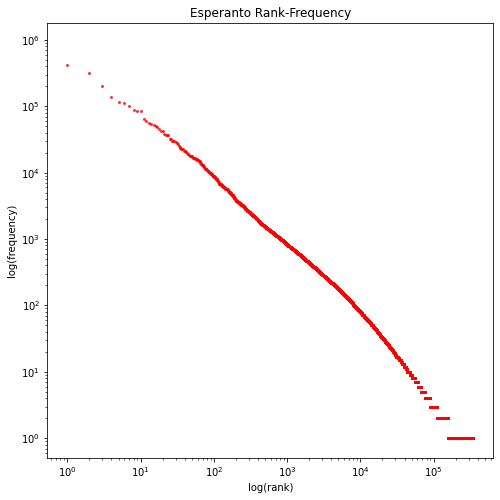

In [3]:
# show zipf's law

# alltext = ' ### '.join([re.sub('[!?.]',' ### ', re.sub('[,–;:”“*]|\.\.\.', '', c.text)).lower() for c in corpora])
alltext = ' '.join([re.sub('[!?.,;:”“()=+*\–\-/\d]', '', c.text).lower() for c in corpora])

freq = {}
for t in alltext.split():
    freq[t] = freq.get(t, 0) + 1
freq = [(freq[k], k) for k in freq]
freq.sort(reverse=True)

tot = len(freq)
fig = plt.figure(figsize=(8,8))
ax  = plt.axes()
ax.loglog([x[0] for x in freq[:tot]],'o', alpha=0.8, markersize=3, color='r', markeredgecolor='none')
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)
ax.set_title("Esperanto Rank-Frequency")
ax.set_xlabel("log(rank)")
ax.set_ylabel("log(frequency)")
# ax.grid(True)
plt.savefig('esperanto-rank-freq')
plt.show()


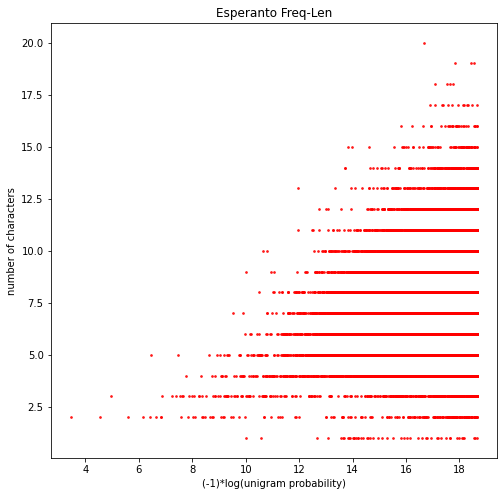

SpearmanrResult(correlation=0.197476395863429, pvalue=3.048047201333645e-218)


In [4]:
# frequency-length plot/correlation

tot = 25000
L = len(alltext.split())
x = np.array([-math.log2(e[0]/L) for e in freq[:tot]])
y = np.array([len(e[1]) for e in freq[:tot]])

fig = plt.figure(figsize=(8,8))
ax  = plt.axes()
ax.scatter(x,y,s=3,c='r',alpha=0.8)
ax.set_title("Esperanto Freq-Len") # ($\\rho=0.1975$)
ax.set_xlabel("(-1)*log(unigram probability)")
ax.set_ylabel("number of characters")
# ax.grid(True)
plt.savefig('esperanto-freq-len')
plt.show()

print(stats.spearmanr(x,y))

In [6]:
# create n-gram model object

class Model():
    def __init__(self, N):
        assert N > 0
        self.N = int(N)
        self.L = 0  # number of words in corpus
        self.G = 0  # number of (N-1)-grams (contexts)
        self.C = {} # all possible contexts [ (N-1)-grams ] { "context string" -> { "words": {"nextWord" -> frequency} , "size": sum(frequency) }
        self.W = {} # all possible words { "word" -> frequency }
        self.trained = False
        self.E = None
        return
    #
    def train(self, corpus, split=False):
        # todo -- handle start/end of sentences?
        print("training.")
        start_time = time.time()
        # expect corpus == 'all words in corpora'
        if not split: corpus = corpus.split()
        self.L = len(corpus)
        self.G = self.L-self.N+1
        for i in range(self.G-1):
            c = ' '.join(corpus[i:i+self.N-1]) # index by N-1 gram
            if self.C.get(c) is None: self.C[c] = {"words":{},"size":0} # new context
            self.C[c]["words"][corpus[i+self.N]] = self.C[c]["words"].get(corpus[i+self.N],0) + 1
            self.C[c]["size"] += 1
        for i in range(self.L):
            self.W[corpus[i]] = self.W.get(corpus[i],0) + 1
        print("training took {} seconds".format(time.time() - start_time))
        self.trained = True
        return self.trained
    #
    def ready(self):
        return self.trained
    #
    def eq1(self, wl, recompute=False):
        # wl = list of words w
        # need to compute -sum_c P(C=c|W=w)*logP(W=w|C=c)
        # using P(W=w|C=c) estimated with N-gram model
        #
        # P(C=c|W=w) = P(C=c and W=w) / P(W=w) = (self.C[c][w] / self.G) / (self.W[w] / self.L)
        # P(W=w|C=c) = P(W=w and C=c) / P(C=c) = self.C[c][w] / size(self.C[c])
        #
        # ez
#         e = [0]*len(wl)
#         for c in self.C:
#             for i,w in enumerate(wl):
#                 pcw = (self.C[c]["words"].get(w,0) / self.G) / (self.W[w] / self.L)
#                 pwc = self.C[c]["words"].get(w,0) / self.C[c]["size"]
#                 e[i] += pcw * (math.log(pwc,2) if pwc > 0 else 0)
#         return [-x for x in e]
        #
        # maybe this:
        # [1] =? -1/n sum log P(W=w|C=c_i)
        # n = frequency of w in corpus
        # c_i = context for the i-th occurrence of w
        t = {}
        if recompute:
            self.E = None
        if self.E is None:
            self.E = {w:0 for w in self.W}
            for c in self.C:
                # { "context string" -> { "words": {"nextWord" -> frequency} , "size": sum(frequency) }
                for w in self.C[c]["words"]:
                    # log2(number of times this word context appears) (number of N-grams ending in w)
                    # log2(number of times this context appears) (number of N-1-grams)
                    self.E[w] -= (math.log2(self.C[c]["words"][w]) - math.log2(self.C[c]["size"])) * self.C[c]["words"][w]
                    t[w] = t.get(w,0)+self.C[c]["words"][w]
            for w in t:
                if t[w] != self.W[w]:
                    print(w, t[w], self.W[w])
                    self.W[w] = t[w]
        return [self.E[w]/self.W[w] for w in wl]
    #
#

training.
training took 13.02545690536499 seconds
i 635 636
estis 55317 55318
took 4.572021245956421 seconds


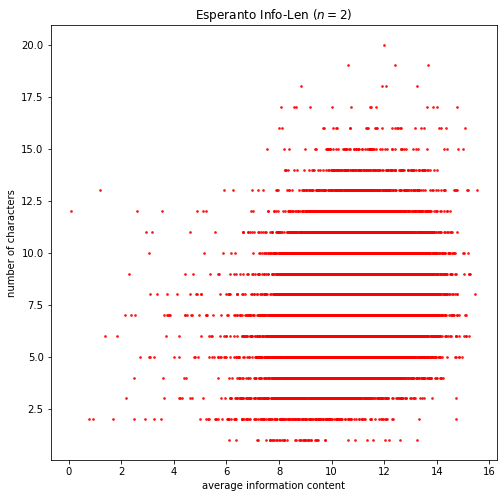

SpearmanrResult(correlation=0.14756629684906414, pvalue=1.053769107710977e-121)


In [6]:
# bi-gram model

m = Model(2)
m.train( alltext )
assert m.ready()

start_time = time.time()
info_content = m.eq1([e[1] for e in freq[:tot]])
print("took {} seconds".format(time.time() - start_time))

x = np.array(info_content)
y = np.array([len(e[1]) for e in freq[:tot]])

fig = plt.figure(figsize=(8,8))
ax  = plt.axes()
ax.scatter(x,y,s=3,c='r',alpha=0.8)
ax.set_title("Esperanto Info-Len ($n=2$)") # ($\\rho=0.1476$)
ax.set_xlabel("average information content")
ax.set_ylabel("number of characters")
# ax.grid(True)
plt.savefig('esperanto-info2-len')
plt.show()

print(stats.spearmanr(x,y))

training.
training took 21.19860601425171 seconds
estis 55317 55318
sabata 50 51
i 635 636
took 9.170813083648682 seconds


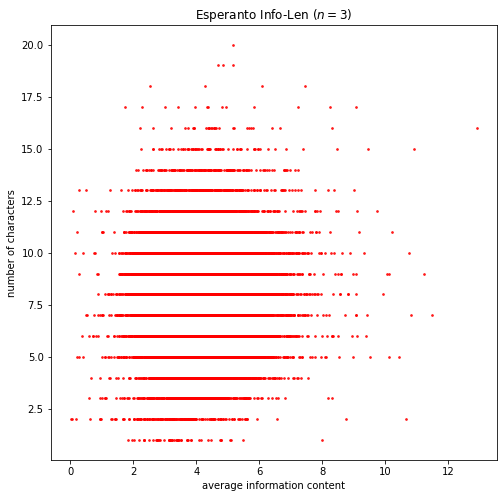

SpearmanrResult(correlation=0.038573693990934306, pvalue=1.0540556346567935e-09)


In [7]:
# tri-gram model

m = Model(3)
m.train( alltext )
assert m.ready()

start_time = time.time()
info_content = m.eq1([e[1] for e in freq[:tot]])
print("took {} seconds".format(time.time() - start_time))

x = np.array(info_content)
y = np.array([len(e[1]) for e in freq[:tot]])

fig = plt.figure(figsize=(8,8))
ax  = plt.axes()
ax.scatter(x,y,s=3,c='r',alpha=0.8)
ax.set_title("Esperanto Info-Len ($n=3$)") # ($\\rho=0.1476$)
ax.set_xlabel("average information content")
ax.set_ylabel("number of characters")
# ax.grid(True)
plt.savefig('esperanto-info3-len')
plt.show()

print(stats.spearmanr(x,y))

In [4]:
indices = [] # (start,end+1) indices representing the chunks
split_esperanto_corpora = []
curr = 0
for c in corpora:
    data = re.sub('[!?.,;:”“()=+*\–\-/\d]', '', c.text).lower().split()
    split_esperanto_corpora.extend(data)
    indices.append([curr,curr+len(data)])
    curr += len(data)
#
print(len(split_esperanto_corpora), curr)

9849678 9849678


In [24]:
# repeat the English rho growth rate chart for Esperanto

# can only do so much though...

def trial(thresh):
    print('*')
    output = []
    # get random list of indices
    perm = np.random.permutation(list(range(0,len(indices))))
    sub_allesperanto = []
    i = 0
    while i < len(perm) and len(sub_allesperanto) < thresh:
        s,e = indices[perm[i]]
        sub_allesperanto.extend(split_esperanto_corpora[s:e])
        i += 1
    output.append(len(sub_allesperanto))

    # zipf
    freqse = {}
    for t in sub_allesperanto:
        freqse[t] = freqse.get(t, 0) + 1
    freqse = [(freqse[k], k) for k in freqse]
    freqse.sort(reverse=True)
    freqse = freqse[:25000]

    # freq-len
    x = np.array([-math.log(e[0]/len(sub_allesperanto)) for e in freqse])
    y = np.array([len(e[1]) for e in freqse])
    output.append(stats.spearmanr(x,y))

    # info-len 2
    sn2 = Model(2)
    sn2.train( sub_allesperanto , split=True )
    assert sn2.ready()
    info_content_sn2 = sn2.eq1([e[1] for e in freqse])
    x = np.array(info_content_sn2)
    y = np.array([len(e[1]) for e in freqse])
    output.append(stats.spearmanr(x,y))
    del sn2

    return output
#

start_time = time.time()
R = {x*1000000:{'len':[], 'fl':[], 'il2':[]} for x in [1,2,3,5,7]}
trials = 10
for thresh in R:
    outlist = []
    for t in range(trials):
        outlist.append( trial(thresh) )
    for t in outlist:
        for idx,key in enumerate(['len','fl','il2']):
            R[thresh][key].append(t[idx])
    print('----- -----')
#
print("took {} seconds".format(time.time() - start_time))


*
training.
training took 1.5430552959442139 seconds
la 112669 112670
krokodiloj 12 13
*
training.
training took 1.213386058807373 seconds
la 82590 82591
enkonduke 4 5
*
training.
training took 1.7886748313903809 seconds
lars 3 4
*
training.
training took 1.0853407382965088 seconds
jenaj 9 10
*
training.
training took 1.8458783626556396 seconds
de 52451 52452
averto 12 13
*
training.
training took 1.0956592559814453 seconds
la 95653 95654
enkonduko 9 10
*
training.
training took 1.2429697513580322 seconds
tiu 5152 5153
enkonduko 27 28
*
training.
training took 1.6643242835998535 seconds
de 62194 62195
paroladoj 28 29
*
training.
training took 1.0541532039642334 seconds
tri 627 628
*
training.
training took 1.508857011795044 seconds
homaranismo 12 13
hilelismo 16 17
----- -----
*
training.
training took 2.4114880561828613 seconds
afriko 347 348
diras 1250 1251
*
training.
training took 3.140383720397949 seconds
parto 1126 1127
unua 2094 2095
*
training.
training took 2.7438125610351562 

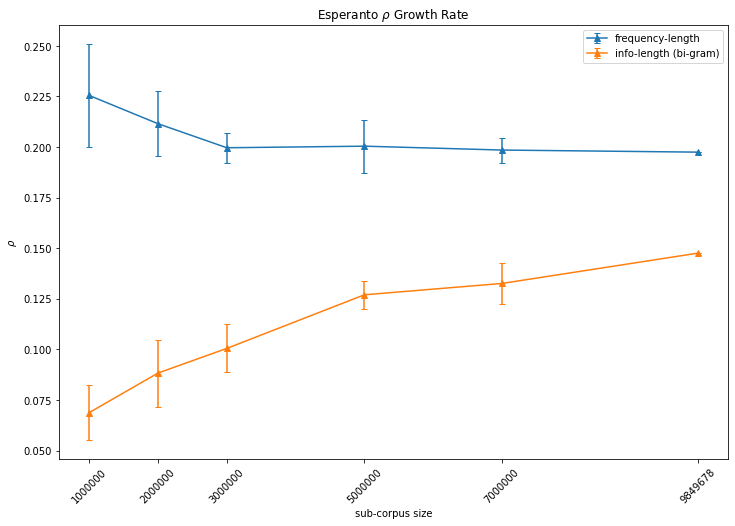

In [27]:
x = [x*1000000 for x in [1,2,3,5,7]]
x.append(indices[-1][1]) # also include entire corpus

fig = plt.figure(figsize=(12,8))
ax  = plt.axes()
for kkey in ['fl','il2']:
    y = []
    e = []
    for key in R:
        sub = [sr.correlation for sr in R[key][kkey]]
        y.append(np.mean(sub))
        e.append(np.std(sub))
    if kkey == 'fl': y.append(0.197476395863429) # values copy-pasted from before.
    else: y.append(0.14756629684906414)
    e.append(0)
    ax.errorbar(x,y,yerr=e,marker='^',capsize=3)
ax.set_title("Esperanto $\\rho$ Growth Rate")
ax.set_xlabel("sub-corpus size")
ax.set_ylabel("$\\rho$")
plt.xticks(x,rotation=45)
plt.ticklabel_format(useOffset=False,style='plain')
ax.legend(['frequency-length','info-length (bi-gram)'])
plt.savefig('esperanto-rho-growth')
plt.show()

In [28]:
R


{1000000: {'len': [1336245,
   1034627,
   1485200,
   1054298,
   1472230,
   1111338,
   1066554,
   1459197,
   1014530,
   1316828],
  'fl': [SpearmanrResult(correlation=0.20197399788028342, pvalue=2.0739821273448867e-228),
   SpearmanrResult(correlation=0.2486271695098042, pvalue=0.0),
   SpearmanrResult(correlation=0.2232816771483924, pvalue=5.639915973307689e-280),
   SpearmanrResult(correlation=0.250307372759031, pvalue=0.0),
   SpearmanrResult(correlation=0.19980202091632465, pvalue=1.809885729153706e-223),
   SpearmanrResult(correlation=0.27428261563948875, pvalue=0.0),
   SpearmanrResult(correlation=0.24168736532620846, pvalue=0.0),
   SpearmanrResult(correlation=0.21243626088315495, pvalue=5.050126976914531e-253),
   SpearmanrResult(correlation=0.1971762371602796, pvalue=1.4248025760960533e-217),
   SpearmanrResult(correlation=0.2052583234106735, pvalue=5.439721872171464e-236)],
  'il2': [SpearmanrResult(correlation=0.08414108188444505, pvalue=1.6158903776182885e-40),
   Sp